$\DeclareMathOperator*{\argmax}{arg\,max}$

# Song Lyrics Emotion Classification, with Gaussian/Multinomial Naive Bayes

## Introduction to Task, Data
_Text classification_ involves both the representation (or embedding) of text as high-dimensional feature vector examples and the classification of those examples. This portion of the project seeks to experiment with different ways of classifying song lyric data with emotion labels, with a focus on text representation/embedding methods. We'll use Naive Bayes as our classification model, which (along with the support vector machine) is particularly suitable for text classification among classical machine learning models for its robustness to high-dimensional data, and experiment with two text embedding methods, term-frequency inverse-document frequency (TFIDF) and word2vec.

## Data Loading/Preprocessing

load data, isolate text and emotion columns, encode labels, remove stop words, encode text (tfidf, word2vec), create train/test splits

First, I'll load in the full dataset and get only the emotion and text columns.

In [93]:
import pandas as pd
NUM_SAMPLES = 100000  # only use a subset of the data, to save on doc2vec training time

full_data = pd.read_csv("spotify_dataset.csv")
data = full_data.sample(n=NUM_SAMPLES, axis="index")
# data = full_data
data = data.reset_index()
data = data[["emotion", "text"]]
del full_data  # full_data is massive (about 1GB), remove from memory

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   emotion  100000 non-null  object
 1   text     100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [94]:
data.isnull().sum()

emotion    0
text       0
dtype: int64

In [95]:
data.value_counts(subset="emotion")

emotion
joy         38012
sadness     31357
anger       19282
fear         5175
love         5120
surprise     1045
True            6
Love            1
interest        1
pink            1
Name: count, dtype: int64

Looks like there are some stray, irregular labels. I'll get rid of every entry with the label "True" and everything below it.

In [97]:
labels = [
    "joy",
    "sadness",
    "anger",
    "fear",
    "love",
    "surprise"
]   
data = data[data["emotion"].isin(labels)]

In [98]:
value_counts = data.value_counts(subset="emotion")
value_counts

emotion
joy         38012
sadness     31357
anger       19282
fear         5175
love         5120
surprise     1045
Name: count, dtype: int64

Considering the class imbalance, I'll obtain a balanced version of the dataset to train on:

In [100]:
lowest = value_counts.min()
data = data.groupby(["emotion"]).sample(lowest)
data.value_counts(subset="emotion")

emotion
anger       1045
fear        1045
joy         1045
love        1045
sadness     1045
surprise    1045
Name: count, dtype: int64

Next, I'll need to encode the emotion labels into integers for the model.

In [102]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_enc = le.fit_transform(data["emotion"])
data["emotion"] = label_enc

label_enc[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Next, I'll prepare the text, which takes some doing: first, I'll have to remove the stopwords, or words that don't hold semantic meaning, like "the" or "and". I'll use the Natural Language Toolkit's bank of stopwords.

In [104]:
from nltk.corpus import stopwords

stopwords = list(set(stopwords.words("english")))
stopwords[:10]

['other',
 'between',
 'doesn',
 'mightn',
 "i'd",
 'any',
 'about',
 'once',
 'such',
 'themselves']

I'll incorporate these stopwords next. Now, let's create the text embeddings, or the numerical representations of the text for use by the model. There are a variety of ways of doing this, from simply encoding each text to a vector of the number of occurrences of each word in the text (_count vectorization_), to a sophisticated, cutting-edge method such as learning a representation using an encoder model like BERT (Bi-directional Encoder Representation Transformer). Here, I'll use two methods between these two: TF-IDF embeddings and word/doc2vec. 

#### TF-IDF

TF-IDF (term-frequency inverse-document-frequency) is the simpler of the two methods. It relies on the product of the term frequency:

(with d = document, t = term, T = all terms, D = all documents)
$$ \begin{equation} TF(t, d) = \frac{d.count(t)}{\sum_{i=0}^{len(d)}d.count(T[i])} \end{equation} $$

with the inverse document frequency:

$$ \begin{equation} IDF(t, D) = \frac{len(D)}{\sum_{i=0}^{len(D)}DF_{t, D[i]}} \end{equation} $$

Where DF_{t, D[i]} is the length of the set of all documents where the term occurs. The term frequency tells you how common the word is in a document, and it is regularized by the inverse document frequency, which tells you how important or notable the word is (the IDF will be lower if the word appears in many documents, indicating it is not so important). This expands on count vectorization by incorporating the contextual importance of a word. Here I'll implement TF-IDF vectorization using sklearn. Note that I use the float32 datatype to allow for memory constraints, and only use the top 500 features (there are many words which are irrelevant and only occur once or twice; remove them):

In [106]:
data_tfidf = data.copy()
data_doc2vec = data.copy()
del data

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import float32

tfidf = TfidfVectorizer(stop_words=list(stopwords), dtype=float32, max_features=500, max_df=0.5)  # max_df=0.5 excludes terms which occur in over 50% of documents
text_enc = tfidf.fit_transform(data_tfidf["text"])
assert len(data_tfidf["text"]) == len(text_enc.toarray())

idx = -1
text_enc = text_enc.toarray()
def update_text(row):
    global idx
    idx += 1
    return text_enc[idx]
data_tfidf["text"] = data_tfidf["text"].apply(update_text)

features_tfidf = tfidf.get_feature_names_out()
len(features_tfidf)

500

In [108]:
features_tfidf[:100]

array(['act', 'afraid', 'ah', 'air', 'alive', 'alone', 'along', 'already',
       'alright', 'always', 'another', 'anything', 'arms', 'around',
       'ask', 'ass', 'away', 'ay', 'aye', 'ayy', 'babe', 'baby', 'back',
       'bad', 'bag', 'bang', 'beat', 'beautiful', 'bed', 'behind',
       'believe', 'best', 'better', 'big', 'bit', 'bitch', 'bitches',
       'black', 'block', 'blood', 'blow', 'blue', 'body', 'boom', 'born',
       'bout', 'boy', 'boys', 'break', 'breathe', 'bridge', 'bring',
       'broke', 'broken', 'brother', 'burn', 'call', 'called', 'calling',
       'came', 'car', 'care', 'cash', 'catch', 'caught', 'cause',
       'chance', 'change', 'check', 'chorus', 'city', 'close', 'club',
       'cold', 'come', 'comes', 'comin', 'coming', 'control', 'cool',
       'could', 'crazy', 'cry', 'cut', 'cuz', 'da', 'damn', 'dance',
       'dark', 'day', 'days', 'dead', 'death', 'deep', 'dem', 'diamonds',
       'dick', 'die', 'different', 'dog'], dtype=object)

## (Attempted) Text Feature Visualization

Next, I'll use dimensionality reduction techniques to try to visualize the text embeddings in 2D space. First, I'll use TruncatedSVD (also known as Latent Semantic Analysis), which is similar to PCA but works especially well with sparse vectors (which is the case with our TF-IDF vectors). I'll use it to reduce the vectors partway, which is recommended before the next step. I'll follow that with t-SNE (t-distributed Stochastic Neighbor Embeddings), which is a dimensionality reduction technique for reducing high-dimensional vectors to low-dimensional (2D or 3D) vectors, while still preserving vector distances as well as possible. Specifically, t-SNE tries to minimize the difference (using Kullback-Leibler divergence, which, intuitively, is a measure of the difference between two distributions) between the distribution of data in high-dimensional space and low-dimensional space.

<Axes: xlabel='encoding1', ylabel='encoding2'>

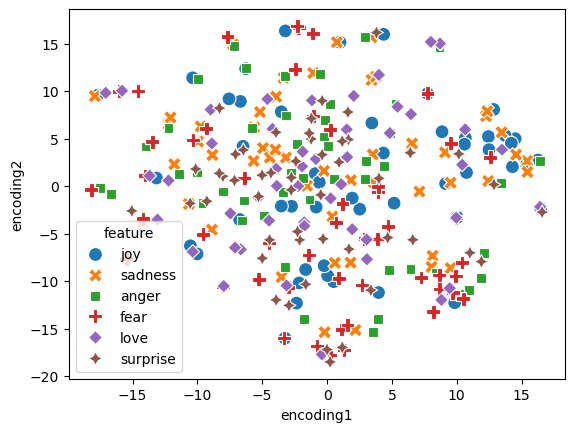

In [110]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import numpy as np

text_enc_chosen = []
labels_df = []
for feat in labels:
    text_enc_label = data_tfidf[data_tfidf["emotion"] == labels.index(feat)]
    for i in range(0, 50):  # sample 50 encodings of each label to visualize
        text_enc_chosen.append(text_enc_label.iloc[i]["text"])
        labels_df.append(feat)
text_enc_chosen = np.array(text_enc_chosen)

tsvd = TruncatedSVD(n_components=30)
text_enc_tsvd = tsvd.fit_transform(text_enc_chosen)
assert len(text_enc_tsvd) == len(text_enc_chosen)

tsne = TSNE(perplexity=30)
text_enc_tsne = tsne.fit_transform(text_enc_tsvd)
assert len(text_enc_tsne) == len(text_enc_chosen)


x = pd.Series([vec[0] for vec in text_enc_tsne.tolist()])
y = pd.Series([vec[1] for vec in text_enc_tsne.tolist()])

label_to_text = pd.concat([pd.Series(labels_df), x, y], axis=1)
label_to_text.columns = ["feature", "encoding1", "encoding2"]
sns.scatterplot(data=label_to_text, x="encoding1", y="encoding2", hue="feature", style="feature", s=100)

Obviously, the data looks kind of random. Adjusting hyperparameters (perplexity, num of components for TruncatedSVD, number of text features) doesn't seem to do a whole lot. This seems to be a reflection of the low quality of the emotion annotations, though, as we will see, there is still some insight to be gained and some value in the data.

## Word2Vec and Doc2Vec

Doc2Vec is the other method of text embedding I'll try, which is an extension of the word2vec text embedding algorithm. Rather than a straightforward formula/calculation as with TF-IDF, word2vec relies on shallow neural networks to function. The training process starts by generating randomized word feature vectors for each term in the vocabulary. Then, the neural network learns to predict masked words given the surrounding context of words in some sliding window or subset of the document. As the neural network improves through many iterations of backpropagation/gradient descent, the word feature vectors are adjusted gradually such that they naturally soak in the meaning of the words in their immediate context. Doc2vec expands upon word2vec and allows for one feature vector/embedding for the entire document by also updating a document feature vector concurrently with each word feature vector. At the end of the process, along with the learned word embeddings, a learned document embedding containing learned information about the document is also generated. Here, I'll use gensim's, an NLP library, implementation of doc2vec to create document embeddings for each song's lyrics.

In [112]:
import gensim
import nltk
import string

nltk.download("punkt_tab")

# to log doc2vec model training
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

idx = 0
def tokenize(text):
    global idx
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords]
    tokens = gensim.models.doc2vec.TaggedDocument(tokens,[idx])
    idx += 1
    return tokens
    
data_doc2vec["text"] = data_doc2vec["text"].apply(tokenize)

model = gensim.models.doc2vec.Doc2Vec(vector_size=500, min_count=10, epochs=40, workers=4)
text = data_doc2vec["text"].to_numpy().tolist()
model.build_vocab(text)
model.train(text, total_examples=model.corpus_count, epochs=model.epochs)

idx = 0
def encode(text):
    global idx
    idx += 1
    if idx % 1000 == 0:
        print(f"{idx/len(data_doc2vec)*100}% done encoding")
    return model.infer_vector(text.words)

data_doc2vec["text"] = data_doc2vec["text"].apply(encode)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\uzarn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-05-03 20:00:11,465 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d500,n5,w5,mc10,s0.001,t4>', 'datetime': '2025-05-03T20:00:11.465348', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'created'}
2025-05-03 20:00:11,477 : INFO : collecting all words and their counts
2025-05-03 20:00:11,479 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2025-05-03 20:00:11,883 : INFO : collected 56703 word types and 6270 unique tags from a corpus of 6270 examples and 1378141 words
2025-05-03 20:00:11,883 : INFO : Creating a fresh vocabulary
2025-05-03 20:00:11,955 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=10 retains 9515 unique words (16.78% of 

0.1594896331738437% done encoding
0.3189792663476874% done encoding
0.4784688995215311% done encoding
0.6379585326953748% done encoding
0.7974481658692185% done encoding
0.9569377990430622% done encoding


I'll do the same visualization as with TF-IDF, but this time using PCA instead of TruncatedSVD (TruncatedSVD is particularly powerful on TF-IDF embeddings).

<Axes: xlabel='encoding1', ylabel='encoding2'>

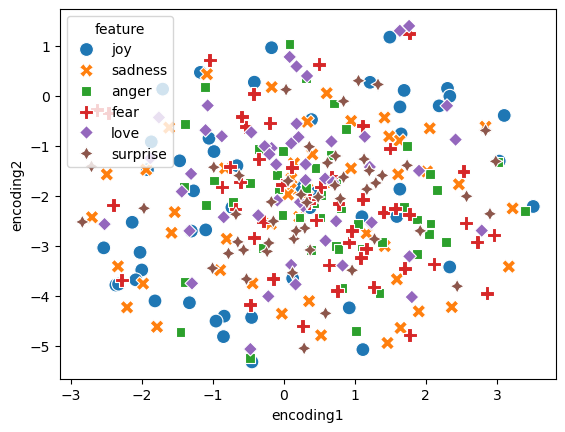

In [117]:
from sklearn.decomposition import PCA

labels = [
    "joy",
    "sadness",
    "anger",
    "fear",
    "love",
    "surprise"
]    

text_enc_chosen = []
labels_df = []
for feat in labels:
    text_enc_label = data_doc2vec[data_doc2vec["emotion"] == labels.index(feat)]
    for i in range(0,50):
        text_enc_chosen.append(text_enc_label.iloc[i]["text"])
        labels_df.append(feat)
text_enc_chosen = np.array(text_enc_chosen)

pca = PCA(n_components=50)
text_enc_pca = pca.fit_transform(text_enc_chosen)

tsne = TSNE(perplexity=30)
text_enc_tsne = tsne.fit_transform(text_enc_pca)

x = pd.Series([vec[0] for vec in text_enc_tsne.tolist()])
y = pd.Series([vec[1] for vec in text_enc_tsne.tolist()])

label_to_text = pd.concat([pd.Series(labels_df), x, y], axis=1)
label_to_text.columns = ["feature", "encoding1", "encoding2"]
sns.scatterplot(data=label_to_text, x="encoding1", y="encoding2", hue="feature", style="feature", s=100)

## Gaussian and Multinomial Naive Bayes with TF-IDF text embeddings
#### + rationale/explanation for Naive Bayes

Naive Bayes relies on the Bayes' Theorem, $p(a|b) = \frac{p(b|a)p(a)}{p(b)}$, which is powerful because it relates a conditional probability to its inverse ($p(a|b)$ to $p(b|a)$). This can be useful for a classification task as it allows you to find the conditional probability of a class label given an example, like $p(label|x) = \frac{p(x|label)p(label)}{p(x)}$, which can be simplified and modified to find the maximally likely label probability like $p(label|x) = \argmax{p(x|label)p(label)}$ (as there is no need to maximize the denominator because it is a constant term). Furthermore, the assumption is made that all features are conditionally independent, meaning $p(x|label) = \prod{p(x_{i}|label)}$, which drastically simplifies the calculation with the side effect that Naive Bayes is only good for _classification_ and not actually predicting probability values, as the independence assumption will throw this number off. 

Naive Bayes is considered a strong choice for text and document classification tasks like this one, because it is robust to what is called the _curse of dimensionality_, or in general, the breakdown of the relationship between feature vectors in a high-dimensional space in machine learning. Naive Bayes avoids this because of its independence assumption and use of probability theory rather than gradient descent-based learning. It is also computationally lightweight compared to other classification models, like the support vector machine or perception.

Multinomial Naive Bayes, typically used for document classification, assumes $p(x|label)$ can be modeled by a multinomial distribution, where each event in the distribution is a feature in a feature vector. In this case, each event would be a TF-IDF feature for each document vector. Gaussian Naive Bayes, on the other hand, assumes $p(x|label)$ models a normal distribution.

In [131]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import copy

X = data_tfidf["text"].to_numpy().tolist()
y = data_tfidf["emotion"].to_numpy().tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gnb_tfidf = GaussianNB()
gnb_tfidf.fit(X_train, y_train)
y_hat = gnb_tfidf.predict(X_test)

I'll use sklearn's classification report function, which provides a macro and label-by-label breakdown of the performance of the model (including precision, recall, accuracy, F1). 

In [133]:
tfidf_report = classification_report(list(y_test), list(y_hat), labels=[num for num in range(len(labels))], target_names=labels, output_dict=True)
tfidf_report

{'joy': {'precision': 0.37209302325581395,
  'recall': 0.47761194029850745,
  'f1-score': 0.41830065359477125,
  'support': 201.0},
 'sadness': {'precision': 0.2727272727272727,
  'recall': 0.24120603015075376,
  'f1-score': 0.256,
  'support': 199.0},
 'anger': {'precision': 0.1858974358974359,
  'recall': 0.14795918367346939,
  'f1-score': 0.16477272727272727,
  'support': 196.0},
 'fear': {'precision': 0.35195530726256985,
  'recall': 0.29577464788732394,
  'f1-score': 0.32142857142857145,
  'support': 213.0},
 'love': {'precision': 0.26394052044609667,
  'recall': 0.29583333333333334,
  'f1-score': 0.27897838899803534,
  'support': 240.0},
 'surprise': {'precision': 0.3148148148148148,
  'recall': 0.33170731707317075,
  'f1-score': 0.32304038004750596,
  'support': 205.0},
 'accuracy': 0.29904306220095694,
 'macro avg': {'precision': 0.29357139573400065,
  'recall': 0.29834874206942646,
  'f1-score': 0.2937534535569352,
  'support': 1254.0},
 'weighted avg': {'precision': 0.2937388

And a confusion matrix for results visualization.

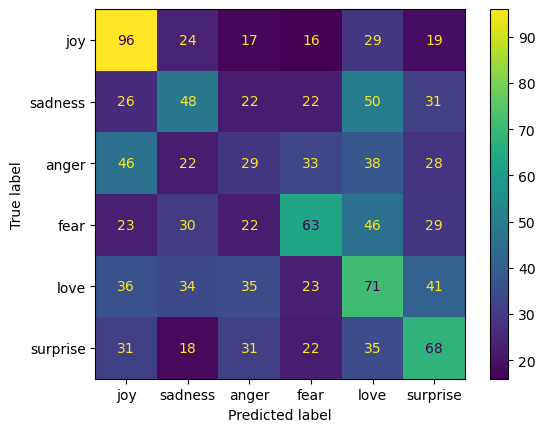

In [136]:
cm = confusion_matrix(y_test, y_hat, labels=[num for num in range(len(labels))])
display = ConfusionMatrixDisplay(cm, display_labels=labels)
display.plot()

I'll do the same procedure for multinomial Naive Bayes:

In [138]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import copy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gnb_tfidf = MultinomialNB()
gnb_tfidf.fit(X_train, y_train)
y_hat = gnb_tfidf.predict(X_test)

tfidf_report = classification_report(list(y_test), list(y_hat), labels=[num for num in range(len(labels))], target_names=labels, output_dict=True)
tfidf_report

{'joy': {'precision': 0.37254901960784315,
  'recall': 0.5,
  'f1-score': 0.42696629213483145,
  'support': 228.0},
 'sadness': {'precision': 0.32051282051282054,
  'recall': 0.24509803921568626,
  'f1-score': 0.2777777777777778,
  'support': 204.0},
 'anger': {'precision': 0.2546583850931677,
  'recall': 0.22162162162162163,
  'f1-score': 0.23699421965317918,
  'support': 185.0},
 'fear': {'precision': 0.4482758620689655,
  'recall': 0.49523809523809526,
  'f1-score': 0.47058823529411764,
  'support': 210.0},
 'love': {'precision': 0.3147410358565737,
  'recall': 0.395,
  'f1-score': 0.35033259423503327,
  'support': 200.0},
 'surprise': {'precision': 0.46621621621621623,
  'recall': 0.3039647577092511,
  'f1-score': 0.368,
  'support': 227.0},
 'accuracy': 0.36443381180223283,
 'macro avg': {'precision': 0.3628255565592644,
  'recall': 0.36015375229744234,
  'f1-score': 0.3551098531824899,
  'support': 1254.0},
 'weighted avg': {'precision': 0.36710910078494274,
  'recall': 0.3644338

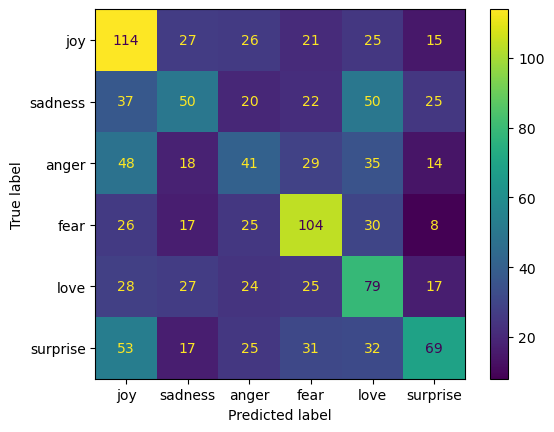

In [140]:
cm = confusion_matrix(y_test, y_hat, labels=[num for num in range(len(labels))])
display = ConfusionMatrixDisplay(cm, display_labels=labels)
display.plot()

## Gaussian Naive Bayes w/ doc2vec text embeddings

Now I'll try Naive Bayes with the doc2vec text embeddings. Unfortunately, multinomial Naive Bayes is incompatible with doc2vec embeddings, because features can be negative, and multinomial Naive Bayes assumes each feature is a probability. Gaussian Naive Bayes, however, is still compatible, because features are input to a Gaussian (normal) distribution.

In [143]:
X = data_doc2vec["text"].to_numpy().tolist()
y = data_doc2vec["emotion"].to_numpy().tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gnb_doc2vec = GaussianNB()
gnb_doc2vec.fit(X_train, y_train)
y_hat = gnb_doc2vec.predict(X_test)

doc2vec_report = classification_report(list(y_test), list(y_hat), labels=[num for num in range(len(labels))], target_names=labels, output_dict=True)
doc2vec_report

{'joy': {'precision': 0.3129973474801061,
  'recall': 0.5728155339805825,
  'f1-score': 0.40480274442538594,
  'support': 206.0},
 'sadness': {'precision': 0.2978723404255319,
  'recall': 0.1346153846153846,
  'f1-score': 0.18543046357615894,
  'support': 208.0},
 'anger': {'precision': 0.21518987341772153,
  'recall': 0.08333333333333333,
  'f1-score': 0.12014134275618374,
  'support': 204.0},
 'fear': {'precision': 0.2716049382716049,
  'recall': 0.5188679245283019,
  'f1-score': 0.3565640194489465,
  'support': 212.0},
 'love': {'precision': 0.24880382775119617,
  'recall': 0.2549019607843137,
  'f1-score': 0.25181598062953997,
  'support': 204.0},
 'surprise': {'precision': 0.3111111111111111,
  'recall': 0.12727272727272726,
  'f1-score': 0.18064516129032257,
  'support': 220.0},
 'accuracy': 0.28149920255183414,
 'macro avg': {'precision': 0.27626323974287864,
  'recall': 0.28196781075244054,
  'f1-score': 0.2498999520210896,
  'support': 1254.0},
 'weighted avg': {'precision': 0

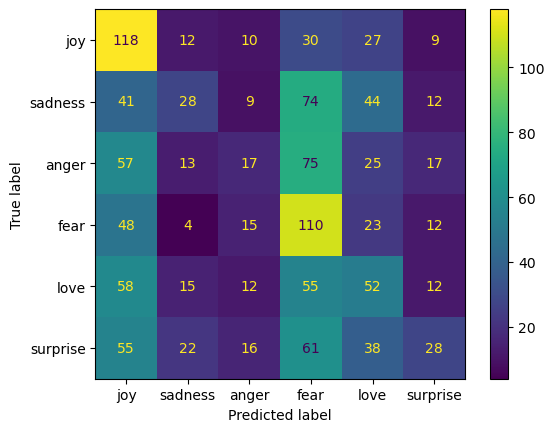

In [145]:
cm = confusion_matrix(y_test, y_hat, labels=[num for num in range(len(labels))])
display = ConfusionMatrixDisplay(cm, display_labels=labels)
display.plot()

## Impact, reminder about emotion label data
Predicting emotion could be useful for streaming services (like Spotify, the service our data is sourced from) that want to develop recommender systems that incorporate song emotion but only have access to a song's lyrics, not its emotion. This could improve user experience by streamlining song discovery. On the other hand, while it might be less applicable to Spotify, some social media recommender systems (like TikTok's or YouTube's "algorithm") often contribute to the addictiveness of the service. 

Also note that the emotion label in our training data was itself generated using a machine learning model. The authors of the dataset used a T5 transformer fine-tuned for emotion classification to classify lyrics with an emotion label. While a fine-tuned transformer is almost always going to outperform Naive Bayes, and so the label annotations as a source of "ground truth" are still valid to an extent, they are probably less suitable for training Naive Bayes when compared to human-annotated labels. Unfortunately, in this case, it seems like the fine-tuned model didn't perform so well, or perhaps that our data is not cleanly separable, given the poor results and failed t-SNE visualization.

## Conclusion

In conclusion, despite likely problems with our data, this project still shows that multinomial Naive Bayes is the stronger model and doc2vec provides more robust embeddings for text classification. I've learned a lot about the types of Naive Bayes models and some powerful text embedding methods, and I would like to continue in this direction by working with transformer-based encoders like BERT for text classification.

#### References

Overleaf for LaTeX, and Sklearn, pandas, NLTK documentation
https://www.ibm.com/think/topics/naive-bayes
https://stackoverflow.com/questions/13208286/how-to-write-latex-in-ipython-notebook
https://www.datacamp.com/blog/curse-of-dimensionality-machine-learning
https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
https://en.wikipedia.org/wiki/Tf%E2%80%93idf
https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
https://www.statology.org/pandas-find-first-row-that-meets-criteria/
https://stackoverflow.com/questions/38840319/put-a-2d-array-into-a-pandas-series
https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/
https://stackoverflow.com/questions/15547409/how-to-get-rid-of-punctuation-using-nltk-tokenizer
https://stackoverflow.com/questions/66280588/class-weight-balanced-equivalent-for-naive-bayes